## Named Entity Recognition

NER or Named Entity Recoginition is a task to recognize names, organization, timestamps or similar info in a text document. 

* We will model the classifier with Keras as a LSTM with embedding layers.
* We will be using a labeled dataset from kaggle.

Dataset:
https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus

Keras v2.1.6

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("data/ner_dataset.csv", encoding="latin1")

Data is structured as a list of sentences, words as elements and their POS tag and NER tag. After the row that contains "Sentence: n" in the column named "Sentece #", all following rows until a new "Sentence: n+1" is found will be part of the sentence n.

In [2]:
data.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [3]:
data.tail(10)

,Sentence #,Word,POS,Tag
1048565,NaN,impact,NN,O
1048566,NaN,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,NaN,forces,NNS,O
1048569,NaN,said,VBD,O
1048570,NaN,they,PRP,O
1048571,NaN,responded,VBD,O
1048572,NaN,to,TO,O
1048573,NaN,the,DT,O
1048574,NaN,attack,NN,O


In [4]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
tags = list(set(data["Tag"].values))

print("Num of total words: {}".format(data['Word'].shape[0]))
print("Num of different words: {}".format(len(words)))

Num of total words: 1048575
Num of different words: 35179


What we will do now is to build the actual sentences so we can train the model. First we need some preprocessing to fill in the gaps, then we will build a small helper to perform the construction of these sentences.

In [5]:
data["Sentence #"] = data["Sentence #"].fillna(method="ffill")
data.head(5)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [6]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s : [(w, p, t) for w, p, t in (zip(s["Word"].values.tolist(),
                                                             s["POS"].values.tolist(),
                                                             s["Tag"].values.tolist()))]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
        
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            self.empty = True
            return None

In [7]:
sg = SentenceGetter(data)
print(sg.get_next())

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [8]:
sentences = sg.sentences
print(len(sentences))

47959


Let's see how long sentences are:

Max length: 104


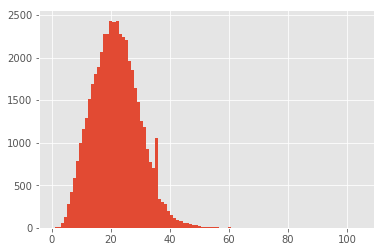

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline  

sentences_lengs = [len(s) for s in sentences]
print("Max length: {}".format(max(sentences_lengs)))

plt.style.use("ggplot")
plt.hist(sentences_lengs, bins = 100)
plt.show()

In Keras we need padding for sentences. This means that all sentences will have a padding until reaching the max sentence length. We will use a length of 50. This leaves some out of the way but not many.

We also need word and tags dictionaries.

In [10]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

print(word2idx['Obama'])
print(tag2idx['B-geo'])

15492
6


Now we will map these ids to the real sequences, building sequences based on just ids. Both for words and tags.

In [11]:
from keras.preprocessing.sequence import pad_sequences

max_len = 50
n_words = len(words)
n_tags = len(tags)

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

Using TensorFlow backend.


In [12]:
print("Sentence: {}".format(sentences[1]))
print("Mapped sentence: {}".format(X[1]))

Sentence: [('Iranian', 'JJ', 'B-gpe'), ('officials', 'NNS', 'O'), ('say', 'VBP', 'O'), ('they', 'PRP', 'O'), ('expect', 'VBP', 'O'), ('to', 'TO', 'O'), ('get', 'VB', 'O'), ('access', 'NN', 'O'), ('to', 'TO', 'O'), ('sealed', 'JJ', 'O'), ('sensitive', 'JJ', 'O'), ('parts', 'NNS', 'O'), ('of', 'IN', 'O'), ('the', 'DT', 'O'), ('plant', 'NN', 'O'), ('Wednesday', 'NNP', 'B-tim'), (',', ',', 'O'), ('after', 'IN', 'O'), ('an', 'DT', 'O'), ('IAEA', 'NNP', 'B-org'), ('surveillance', 'NN', 'O'), ('system', 'NN', 'O'), ('begins', 'VBZ', 'O'), ('functioning', 'VBG', 'O'), ('.', '.', 'O')]
Mapped sentence: [  332  5852  8544  9249 14025 24617 25685 13567 24617  6200  8022 16813
 22529 25461 13130  6092 15905 30427 15287 20212 13859  5776  4151 31145
 25881 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178]


Now we need to conver y to categorical.

In [13]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

Almost there, we need to perform train and test split.

In [14]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

We will use the functional API of Keras to build the model.

In [15]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

input = Input(shape=(max_len,))

model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)

model = Model(input, out)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [16]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5, validation_split=0.1, verbose=1)

Train on 38846 samples, validate on 4317 samples
Epoch 1/5
38846/38846 [==============================] - 193s 5ms/step - loss: 0.1407 - acc: 0.9647 - val_loss: 0.0630 - val_acc: 0.9819
Epoch 2/5
38846/38846 [==============================] - 189s 5ms/step - loss: 0.0552 - acc: 0.9839 - val_loss: 0.0511 - val_acc: 0.9851
Epoch 3/5
38846/38846 [==============================] - 189s 5ms/step - loss: 0.0460 - acc: 0.9866 - val_loss: 0.0490 - val_acc: 0.9856
Epoch 4/5
38846/38846 [==============================] - 189s 5ms/step - loss: 0.0414 - acc: 0.9879 - val_loss: 0.0456 - val_acc: 0.9864
Epoch 5/5
38846/38846 [==============================] - 189s 5ms/step - loss: 0.0385 - acc: 0.9886 - val_loss: 0.0453 - val_acc: 0.9863


Below we check some predictions and print them

In [17]:
i = 500

# predicted labels
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)

# real labels
r = np.argmax(y_te[i], axis=-1)

print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
print("{:15} ({:5}): {}".format("----", "-", "-"))
for w, real, pred in zip(X_te[i], r, p[0]):
    print("{:15} ({:5}): {}".format(words[w], tags[real], tags[pred]))
    if words[w] == "ENDPAD":
        print("...")
        break

Word            (True ): Pred
----            (-    ): -
The             (O    ): O
U.S.            (B-org): B-org
State           (I-org): I-org
Department      (I-org): I-org
says            (O    ): O
the             (O    ): O
already         (O    ): O
poor            (O    ): O
human           (O    ): O
rights          (O    ): O
situation       (O    ): O
in              (O    ): O
Nepal           (B-gpe): B-gpe
worsened        (O    ): O
in              (O    ): O
the             (O    ): O
past            (B-tim): B-tim
year            (O    ): O
,               (O    ): O
with            (O    ): O
security        (O    ): O
forces          (O    ): O
and             (O    ): O
insurgents      (O    ): O
alike           (O    ): O
committing      (O    ): O
serious         (O    ): O
human           (O    ): O
rights          (O    ): O
abuses          (O    ): O
.               (O    ): O
ENDPAD          (O    ): O
...


Seems we could do better. In fact, we should consider a correct prediction only if all tags are well addressed in the sequence prediction. For now we will just try to improve as this approach **has one big shortcomming: If we haven’t seen a word a prediction time, we have to encode it as unknown and have to infer it’s meaning by it’s surrounding word.**

Often word postfix or prefix contains a lot of information about the meaning of the word. Using this information is very important if you deal with texts that contain a lot of rare words and you expect a lot of unknown words at inference time. For example when you work with medical texts.

To encode the character-level information, we will use character embeddings and a LSTM to encode every word to a vector. We can use basically everything that produces a single vector for a sequence of characters that represent a word. You can also use a max-pooling architecture or a CNN or whatever works for you. Then we feed the vector to another LSTM together with the learned word embedding.

***

## Named Entity Recognition with character level embedding

In this case we are going to train two models. One for sequences and another one for characters. This means we have to create the dictionaries for words, tags and characters. 

First we will map the words and tags and also pad the sequences. Notice the increased max_len and the new max_len_char. Also notice that we got a new tag "UNK" and "PAD" asigned to 1 and 0 values in dictionary respectively.

In [18]:
max_len = 75
max_len_char = 10

word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}

tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [19]:
from keras.preprocessing.sequence import pad_sequences
X_word = [[word2idx[w[0]] for w in s] for s in sentences]

Pad the sentences using the "PAD" word value.

In [20]:
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')

Now we generate the dictionary for characters and create a sequence of characters for every possible word.

In [21]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)
print(chars)

98
{'_', 'ë', '?', '°', 'x', 'y', 'Q', '(', '[', 'H', 'W', 'C', 's', 'L', 'U', 'M', '.', '6', '%', 'O', 'o', '\x96', 'T', 'g', '+', '\x85', 'P', "'", '8', 'i', 'h', '\x92', 'R', ']', 'V', 'N', 'r', '-', '\x94', '!', '~', 'I', 'n', 'm', '\x97', 'G', ':', '#', 'K', '/', '$', 'X', 'v', '7', '`', 'k', ',', '@', 't', 'b', '5', 'ö', 'S', '3', 'j', 'e', '"', 'F', '\x91', 'Y', 'J', 'B', 'u', 'd', 'D', 'Z', 'é', 'ü', '9', 'A', 'q', 'E', '1', 'f', '&', '\x93', 'z', 'a', 'w', ')', ';', '\xa0', '2', '0', 'p', 'c', '4', 'l'}


In [22]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

char2idx["Z"]

77

Create the character model dataset.

In [23]:
X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

Mapping and padding for the tags.

In [24]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]


In [25]:
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')


Finally, train and test split for both datasets.

In [26]:
from sklearn.model_selection import train_test_split

X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=2018)

Definition of the models. 

We will create embeddings for the characters. Once we got the encodings of characters, we will get the encodings of words based on these character encodings.

The input data of the main LSTM will be both the word embedding and character encoding.

In [27]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout
from keras.layers import Bidirectional, concatenate, SpatialDropout1D

# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                     input_length=max_len, mask_zero=True)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char, mask_zero=True))(char_in)

# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="softmax"))(main_lstm)

model = Model([word_in, char_in], out)

In [28]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])


In [29]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 75, 10)       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 75)           0                                            
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 75, 10, 10)   1000        input_3[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 75, 20)       703620      input_2[0][0]                    
__________________________________________________________________________________________________
time_distr

In [30]:
history = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=64, epochs=10, validation_split=0.1, verbose=1)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 189s 5ms/step - loss: 0.5533 - acc: 0.8740 - val_loss: 0.2511 - val_acc: 0.9219
Epoch 2/10
38846/38846 [==============================] - 185s 5ms/step - loss: 0.1993 - acc: 0.9421 - val_loss: 0.1541 - val_acc: 0.9560
Epoch 3/10
38846/38846 [==============================] - 185s 5ms/step - loss: 0.1357 - acc: 0.9614 - val_loss: 0.1254 - val_acc: 0.9630
Epoch 4/10
38846/38846 [==============================] - 185s 5ms/step - loss: 0.1122 - acc: 0.9676 - val_loss: 0.1165 - val_acc: 0.9655
Epoch 5/10
38846/38846 [==============================] - 185s 5ms/step - loss: 0.0996 - acc: 0.9705 - val_loss: 0.1102 - val_acc: 0.9673
Epoch 6/10
38846/38846 [==============================] - 185s 5ms/step - loss: 0.0913 - acc: 0.9725 - val_loss: 0.1073 - val_acc: 0.9680
Epoch 7/10
38846/38846 [==============================] - 185s 5ms/step - loss: 0.0852 - acc: 0.9740 - val_loss: 0.1054 - v

Now lets see some predictions:

In [31]:
y_pred = model.predict([X_word_te, 
                        np.array(X_char_te).reshape((len(X_char_te),
                        max_len, max_len_char))])

In [32]:
i = 1925
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_word_te[i], y_te[i], p):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))

Word           ||True ||Pred
On             : O     O
Monday         : B-tim B-tim
,              : O     O
British        : B-org B-gpe
Foreign        : I-org O
Secretary      : B-per B-per
Jack           : I-per I-per
Straw          : I-per I-per
said           : O     O
his            : O     O
government     : O     O
has            : O     O
found          : O     O
no             : O     O
evidence       : O     O
the            : O     O
Bush           : B-org B-per
administration : O     O
requested      : O     O
permission     : O     O
to             : O     O
fly            : O     O
terror         : O     O
suspects       : O     O
through        : O     O
Britain        : B-geo B-geo
or             : O     O
its            : O     O
airspace       : O     O
.              : O     O


Of course this is without tuning dropout or learning rate. So we could try with those hyperparameters to begin with.

Another way to check is to create a new sequence and test it with new data. Let's do this.

In [33]:
test_sentence = ["Hawking", "was", "a", "Fellow", "of", "the", "Royal", "Society", ",", "a", "lifetime", "member",
                 "of", "the", "Pontifical", "Academy", "of", "Sciences", ",", "and", "a", "recipient", "of",
                 "the", "Presidential", "Medal", "of", "Freedom", ",", "the", "highest", "civilian", "award",
                 "in", "the", "United", "States", "."]

test_labels = ["B-per", "O", "O", "O", "O", "O", "B-org", "I-org", "O", "O", "O", "O", "O", "O",
              "B-org", "I-org", "I-org", "I-org", "O", "O", "O", "O", "O", "O", "O", "O", "O",
              "O", "O", "O", "O", "O", "O", "O", "O", "B-geo", "I-geo", "O"]

In [34]:
sentences = []
sentences.append(test_sentence)

Now we transform every word to it’s integer index. Note that we mapping unknown words to zero. Normally you would want to add a UNKNOWN token to your vocabulary. Then you cut the vocabulary on which you train the model and replace all uncommon words by the UNKNOWN token. We haven’t done this for simplicity

In [35]:
x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]],
                            padding="post", value=0, maxlen=max_len)

print("Sentences to predict: {}".format(len(sentences)))
print("Sentence Max len: {}".format(max_len))
print("Word Max len: {}".format(max_len_char))

x_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)        
    x_char.append(np.array(sent_seq))


print(x_char)
x_char[0].shape

Sentences to predict: 1
Sentence Max len: 75
Word Max len: 10
[array([[11, 89, 90, 57, 31, 44, 25,  0,  0,  0],
       [90, 89, 14,  0,  0,  0,  0,  0,  0,  0],
       [89,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [69, 67, 99, 99, 22, 90,  0,  0,  0,  0],
       [22, 85,  0,  0,  0,  0,  0,  0,  0,  0],
       [60, 32, 67,  0,  0,  0,  0,  0,  0,  0],
       [34, 22,  7, 89, 99,  0,  0,  0,  0,  0],
       [64, 22, 97, 31, 67, 60,  7,  0,  0,  0],
       [58,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [89,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [99, 31, 85, 67, 60, 31, 45, 67,  0,  0],
       [45, 67, 45, 61, 67, 38,  0,  0,  0,  0],
       [22, 85,  0,  0,  0,  0,  0,  0,  0,  0],
       [60, 32, 67,  0,  0,  0,  0,  0,  0,  0],
       [28, 22, 44, 60, 31, 85, 31, 97, 89, 99],
       [81, 97, 89, 75, 67, 45,  7,  0,  0,  0],
       [22, 85,  0,  0,  0,  0,  0,  0,  0,  0],
       [64, 97, 31, 67, 44, 97, 67, 14,  0,  0],
       [58,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      

(75, 10)

In [36]:
print(x_test_sent.shape)
print(np.array(x_char).shape)

p = model.predict([x_test_sent, 
                  np.array(x_char).reshape((len(x_char), max_len, max_len_char))])

p = np.argmax(p, axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Prediction"))
print(30 * "=")

for w, label, pred in zip(test_sentence, test_labels, p[0]):
    print("{:15} {:5} {}".format(w, label, idx2tag[pred]))

(1, 75)
(1, 75, 10)
Word           ||True ||Prediction
Hawking         B-per O
was             O     O
a               O     O
Fellow          O     O
of              O     O
the             O     O
Royal           B-org B-org
Society         I-org I-org
,               O     O
a               O     O
lifetime        O     O
member          O     O
of              O     O
the             O     O
Pontifical      B-org B-org
Academy         I-org I-org
of              I-org I-org
Sciences        I-org I-org
,               O     O
and             O     O
a               O     O
recipient       O     O
of              O     O
the             O     O
Presidential    O     O
Medal           O     B-org
of              O     I-org
Freedom         O     I-org
,               O     O
the             O     O
highest         O     O
civilian        O     O
award           O     O
in              O     O
the             O     O
United          B-geo B-geo
States          I-geo I-geo
.            

### Evaluation metrics

As commented above, we cannot evaluate our sequences in a tag per tag manner without taking care of several details:
* The most common tag will be "O" which we don't really care about. This means that **we can manage 70% ish accuracy without really predicting anything correctly but "O" tags. Not good.**
* It is useful too to see how good we are doing in different tags such as geo, per, org, etc...

This mean we will take a look not at accuracy but at precission, recall and f1-score (harmonic mean of precission and recall). The package seqeval does this for us.

In [37]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

pred_tags = []
for pred in p[0]:
    pred_tags.append(idx2tag[pred])

print(classification_report(test_labels, pred_tags))

             precision    recall  f1-score   support

        geo       1.00      1.00      1.00         1
        org       0.67      1.00      0.80         2
        per       0.00      0.00      0.00         1

avg / total       0.58      0.75      0.65         4

